# Import modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn import manifold # for MDS
from sklearn import svm, datasets # for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # for confusion matrix
from sklearn import preprocessing # for numerical labels
from sklearn import metrics # for classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

/Users/chitwood/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Read in data

In [2]:
df = pd.read_csv("./landmark_preliminary.csv") # read in data, one coord per line
mdata = pd.read_csv("./metadata.csv") # read in metadata for later

num_landmarks = 21 # the number of landmarks

n = int(len(df)/num_landmarks) # calculate how many shapes


# Format data into a list of arrays for each leaf shape

In [3]:
shape_list = [] # a list of arrays for each leaf
order_list = [] # create an ordered ID for each leaf as it is read
sample_list = [] # list of sample IDs for each leaf

for i in range(n):
    
    start = 21*i # starting row index for current leaf
    end = start + 21 # ending row index for current leaf
    
    order_list.append("leaf_" + str(i)) # create an ordered ID for each leaf, store in order_list
    sample_list.append(df.iloc[start,2]) # get the current sample ID and store in sample_list
    
    xvals = df.iloc[start:end,3].to_list() # xvals current leaf
    yvals = df.iloc[start:end,4].to_list() # yvals current leaf
    
    leaf_vals = [] # list to store coords for current leaf, one array for each x & y val
     
    for j in range(num_landmarks): # for the number of landmarks
        
        leaf_vals.append([xvals[j], yvals[j]]) # append the current x & y array pair to leaf_vals
        
    leaf_array = np.array(leaf_vals) # turn the current leaf list into an array
    
    shape_list.append(leaf_array) # append the array for each leaf to the overall shape list
    
    
    

# Calculate Procrustes distances to an arbitrary reference to find and remove outliers

#### Remove problematic leaf shapes found while running the code below

In [4]:
##### leaf index 855 was found only to have (0,0) coordinates for all 21 landmarks

shape_list.pop(855)
order_list.pop(855)
sample_list.pop(855)

# leaf index 915 was found only to have (0,0) coordinates for all 21 landmarks
# NOTE: index 915 after removing the above sample FIRST

shape_list.pop(915)
order_list.pop(915)
sample_list.pop(915)

print(len(shape_list), len(order_list), len(sample_list))

1687 1687 1687


#### Calculate Procrustes distances to an arbitrary shape

In [5]:
ref_ind = 0 # select a reference index to calculate procrustes distances to
ref_shape = shape_list[ref_ind] # select the reference shape

dist_list = [] # list to store procrustes distances to reference shape
order_id = [] # list to store order IDs for each leaf

for j in range(len(shape_list)): # len of shape_list, not n, because we deleted some leaves
    
    curr_shape = shape_list[j] # select current leaf shape
    curr_order = order_list[j] # select current order ID
    s1, s2, disparity = procrustes(ref_shape, curr_shape) # perform procrustes analysis
    
    dist_list.append(disparity) # append procrustes distance to dist_list
    order_id.append(curr_order) # append current order ID to order_id


#### Visualize the distribution of the Procrustes distances and determine a cut off for outliers

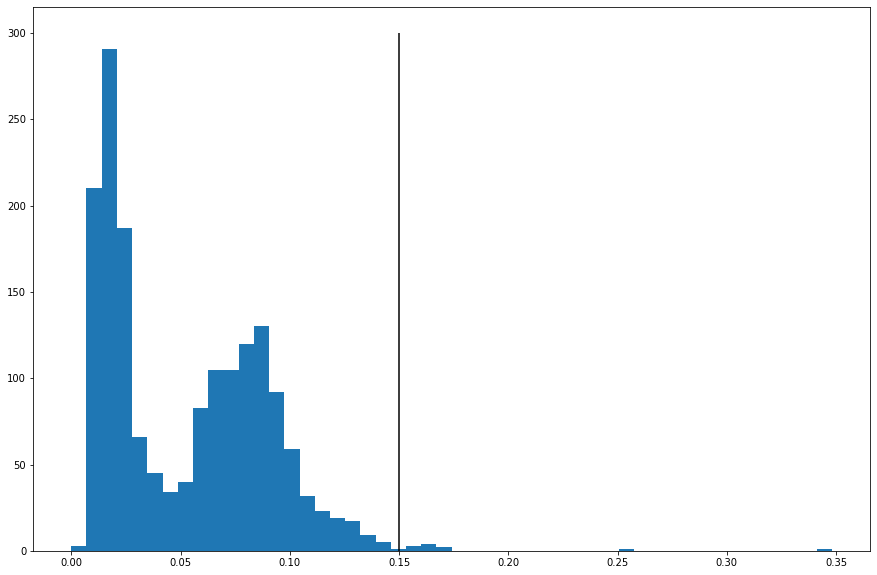

In [6]:
cutoff = 0.15 # Set cut off to >= 0.15

plt.figure(figsize=(15,10))
plt.hist(dist_list, bins=50)
plt.vlines(x=cutoff, ymin=0, ymax=300)

#### Remove outliers

In [7]:
problem_index_vals = []

for k in range(len(dist_list)):
    
    if dist_list[k] >= 0.15:
        problem_index_vals.append(k)
        
print(problem_index_vals)  

[434, 548, 887, 888, 889, 1040, 1146, 1237, 1349, 1374, 1675]


In [8]:
# remove the problem index values from the sample lists

indices = {434, 548, 887, 888, 889, 1040, 1146, 1237, 1349, 1374, 1675} # specify indices to remove

shape_list = [v for i, v in enumerate(shape_list) if i not in indices] # remove indices from shape_list
order_list = [v for i, v in enumerate(order_list) if i not in indices] # remove indices from order_list
sample_list = [v for i, v in enumerate(sample_list) if i not in indices] # remove indices from sample_list

#### Double check that the outliers have been removed

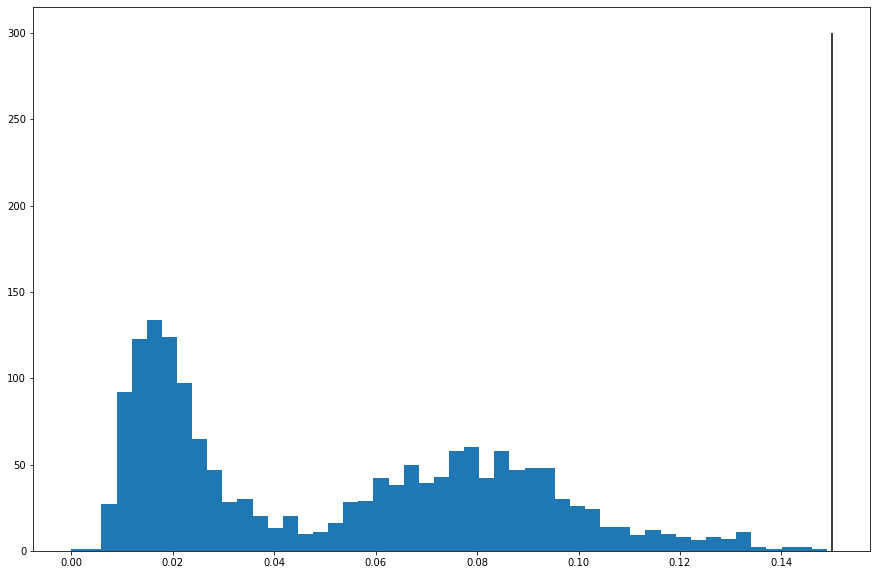

In [9]:
ref_ind = 0 # select a reference index to calculate procrustes distances to
ref_shape = shape_list[ref_ind] # select the reference shape

dist_list = [] # list to store procrustes distances to reference shape
order_id = [] # list to store order IDs for each leaf

for j in range(len(shape_list)): # len of shape_list, not n, because we deleted some leaves
    
    curr_shape = shape_list[j] # select current leaf shape
    curr_order = order_list[j] # select current order ID
    s1, s2, disparity = procrustes(ref_shape, curr_shape) # perform procrustes analysis
    
    dist_list.append(disparity) # append procrustes distance to dist_list
    order_id.append(curr_order) # append current order ID to order_id
    
cutoff = 0.15 # Set cut off to >= 0.15

plt.figure(figsize=(15,10))
plt.hist(dist_list, bins=50)
plt.vlines(x=cutoff, ymin=0, ymax=300)

# Calculate mean Generalized Procrustes Analysis (GPA) shape

In [10]:
ref_ind = 0 # select a reference index to calculate procrustes distances to
ref_shape = shape_list[ref_ind] # select the reference shape

mean_diff = 10**(-30) # set a distance between means to stop the algorithm

old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

d = 1000000 # set d initially arbitraily high

while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations
    
    arr = np.zeros( ((len(shape_list)),21,2) ) # empty 3D array: # samples, 21 landmarks, 2 coord vals

    for i in range(len(shape_list)): # for each leaf shape after removing outliers

        s1, s2, distance = procrustes(old_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
        arr[i] = s2 # store procrustes adjusted shape to array

    new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference
    
    s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean
    
    print("the Procrustes distance between the old and new mean is", d) # print out difference between mean distance
    
    old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration
    
gpa_mean = new_mean


the Procrustes distance between the old and new mean is 0.02295051708326614
the Procrustes distance between the old and new mean is 5.742517179149428e-06
the Procrustes distance between the old and new mean is 2.1707978917898136e-09
the Procrustes distance between the old and new mean is 8.227166898633273e-13
the Procrustes distance between the old and new mean is 3.1182115405959684e-16
the Procrustes distance between the old and new mean is 1.1818463529691631e-19
the Procrustes distance between the old and new mean is 4.479918948644804e-23
the Procrustes distance between the old and new mean is 1.6950011738727837e-26
the Procrustes distance between the old and new mean is 8.340543559988273e-30
the Procrustes distance between the old and new mean is 2.2864399558522216e-31


#### Check the Generalized Procrustes mean shape

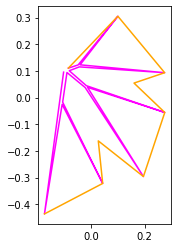

In [11]:
plt.plot(gpa_mean[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         gpa_mean[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], c="magenta")

plt.plot(gpa_mean[[0,13,14,15,16,17,18,19,20],0],
         gpa_mean[[0,13,14,15,16,17,18,19,20],1], c="orange")

plt.gca().set_aspect("equal")

# Calculate Procrustes-adjusted coordinates for each leaf against the calculated mean

In [12]:
proc_arr = np.zeros( ((len(shape_list)),21,2) ) # empty 3D array: # samples, 21 landmarks, 2 coord vals

for i in range(len(shape_list)): # for each leaf shape after removing outliers

    s1, s2, distance = procrustes(gpa_mean, shape_list[i]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

#### Visually check all Procrustes adjusted leaf shapes, plot with the gpa mean leaf

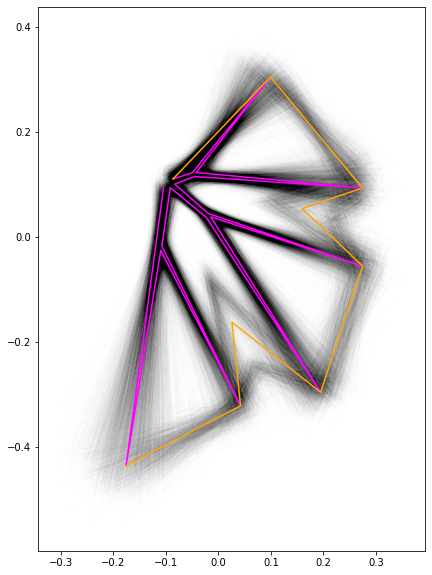

In [13]:
plot_col = "k" # set plot color
a = 0.005 # set alpha

plt.figure(figsize=(10,10))

for i in range(np.shape(proc_arr)[0]):
    
    curr_leaf = proc_arr[i,:,:]

    plt.plot(curr_leaf[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
             curr_leaf[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], alpha=a, c=plot_col)

    plt.plot(curr_leaf[[0,13,14,15,16,17,18,19,20],0],
             curr_leaf[[0,13,14,15,16,17,18,19,20],1], alpha=a, c=plot_col)

    plt.gca().set_aspect("equal")
    
plt.plot(gpa_mean[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         gpa_mean[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], c="magenta")

plt.plot(gpa_mean[[0,13,14,15,16,17,18,19,20],0],
         gpa_mean[[0,13,14,15,16,17,18,19,20],1], c="orange")

plt.gca().set_aspect("equal")

# Combine metadata with shape data and create separate Chardonnay and Cabernet Sauvignon datasets

#### Based on sample ID, create lists storing other metadata

In [14]:
rootstock_list = [] # store rootstock
scion_list = [] # store scion
location_list = [] # store location
year_list = [] # store year

for i in range(len(sample_list)): # for each sample

    curr_sample = sample_list[i] # get current sample

    rootstock = mdata.loc[mdata['sample'] == curr_sample]["rootstock"].values[0] # find corresponding meta data for each sample
    scion = mdata.loc[mdata['sample'] == curr_sample]["scion"].values[0]
    location = mdata.loc[mdata['sample'] == curr_sample]["location"].values[0]
    year = mdata.loc[mdata['sample'] == curr_sample]["year"].values[0]
    
    
    rootstock_list.append(rootstock) # append data to new lists
    scion_list.append(scion)
    location_list.append(location)
    year_list.append(year)
    

In [15]:
# check that all metadata lists are the same length as number of shape samples

print(len(sample_list),len(rootstock_list),len(scion_list),len(location_list),len(year_list)) # lengths of metadata lists

np.shape(proc_arr) # shape of array of shapes

1676 1676 1676 1676 1676


(1676, 21, 2)

#### Create lists of metadata and leaf shapes for ***Chardonnay***, and create a new variable that is a unique identifer of rootstock-location-year

In [16]:
chard_shapes = []
chard_rootstock = []
chard_location = []
chard_year = []
chard_rootstock_location = []
chard_unique = [] 

for i in range(np.shape(proc_arr)[0]):
    
    if scion_list[i] == 'Chardonnay':
        
        chard_shapes.append(proc_arr[i])
        chard_rootstock.append(rootstock_list[i])
        chard_location.append(location_list[i])
        chard_year.append(year_list[i])
        
        chard_rootstock_location.append(
        rootstock_list[i] + "_" + location_list[i]
        )
        
        chard_unique.append(
        rootstock_list[i] + "_" + location_list[i] + "_" + year_list[i]
        )

#### Create lists of metadata and leaf shapes for ***Cabernet Sauvignon***, and create a new variable that is a unique identifer of rootstock-location-year

In [17]:
cab_shapes = []
cab_rootstock = []
cab_location = []
cab_year = []
cab_rootstock_location = []
cab_unique = [] 

for i in range(np.shape(proc_arr)[0]):
    
    if scion_list[i] == 'Cabernet_Sauvignon':
        
        cab_shapes.append(proc_arr[i])
        cab_rootstock.append(rootstock_list[i])
        cab_location.append(location_list[i])
        cab_year.append(year_list[i])
        
        cab_rootstock_location.append(
        rootstock_list[i] + "_" + location_list[i]
        )
        
        
        cab_unique.append(
        rootstock_list[i] + "_" + location_list[i] + "_" + year_list[i]
        )

# Calculate distance matrices and perform multidimensional scaling

## CHARDONNAY

#### For Chardonnay, create a distance matrix, where for each leaf shape (rows), its Procrustes  distance from every other leaf shape (columns).  NOTE: indexing of rows and columns is the same as metadata

In [18]:
chard_dist_arr = np.zeros(  (len(chard_shapes),len(chard_shapes))    )

for i in range(len(chard_shapes)):
    
    if i%100==0:
        print(i)
    
    ref_leaf = chard_shapes[i]
    
    for j in range(len(chard_shapes)):
        
        curr_leaf = chard_shapes[j]
        
        s1, s2, d = procrustes(ref_leaf, curr_leaf)
        
        chard_dist_arr[i][j] = d

0
100
200
300
400
500
600
700
800


#### Calculate average distance of each leaf shape to every other

In [19]:
avg_chard_distances = []

for i in range(np.shape(chard_dist_arr)[0]):
    
    avg_chard_distances.append(np.mean(chard_dist_arr[i]))
    

#### Perform multidimensional scaling

In [20]:
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
mds.fit(chard_dist_arr)
points = mds.embedding_


#### Create dataframe with:

1.  MDS1 values
2.  MDS2 values
3.  rootstock
4.  location
5.  year
6.  location-roostock ID
7.  location-rootstock-year ID (or "unique")
8.  average Procrsutes distance
9.  log average Procrustes distance

In [21]:
chard_df = pd.DataFrame(points, columns=["MDS1","MDS2"])
chard_df["rootstock"] = chard_rootstock
chard_df["location"] = chard_location
chard_df["year"] = chard_year
chard_df["rootstock_location"] = chard_rootstock_location
chard_df["unique"] = chard_unique
chard_df["avg_distance"] = avg_chard_distances
chard_df["log_avg_distance"] = np.log(avg_chard_distances)

#### Visualize results

#### Create MDS plot

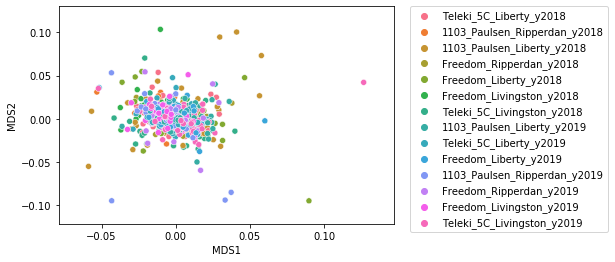

In [22]:
sns.scatterplot(data=chard_df, x="MDS1", y="MDS2", hue="unique")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#### Plot out log of avg distance as boxplot by rootstock-location paired by year

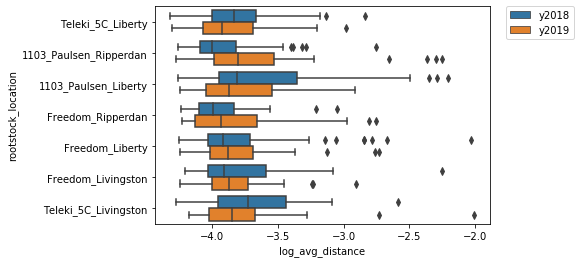

In [23]:
sns.boxplot(data=chard_df, x="log_avg_distance", y="rootstock_location", hue="year", dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## CABERNET SAUVIGNON

#### For Cabernnet Sauvignon, create a distance matrix, where for each leaf shape (rows), its Procrustes distance from every other leaf shape (columns).  NOTE: indexing of rows and columns is the same as metadata

In [24]:
cab_dist_arr = np.zeros(  (len(cab_shapes),len(cab_shapes))    )

for i in range(len(cab_shapes)):
    
    if i%100==0:
        print(i)
    
    ref_leaf = cab_shapes[i]
    
    for j in range(len(cab_shapes)):
        
        curr_leaf = cab_shapes[j]
        
        s1, s2, d = procrustes(ref_leaf, curr_leaf)
        
        cab_dist_arr[i][j] = d

0
100
200
300
400
500
600
700
800


#### Calculate average distance of each leaf shape to every other

In [25]:
avg_cab_distances = []

for i in range(np.shape(cab_dist_arr)[0]):
    
    avg_cab_distances.append(np.mean(cab_dist_arr[i]))

#### Perform multidimensional scaling

In [26]:
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
mds.fit(cab_dist_arr)
points = mds.embedding_

#### Create dataframe with:

1.  MDS1 values
2.  MDS2 values
3.  rootstock
4.  location
5.  year
6.  location-roostock ID
7.  location-rootstock-year ID (or "unique")
8.  average Procrsutes distance
9.  log average Procrustes distance

In [27]:
cab_df = pd.DataFrame(points, columns=["MDS1","MDS2"])
cab_df["rootstock"] = cab_rootstock
cab_df["location"] = cab_location
cab_df["year"] = cab_year
cab_df["rootstock_location"] = cab_rootstock_location
cab_df["unique"] = cab_unique
cab_df["avg_distance"] = avg_cab_distances
cab_df["log_avg_distance"] = np.log(avg_cab_distances)

#### Visualize results

#### Create MDS plot

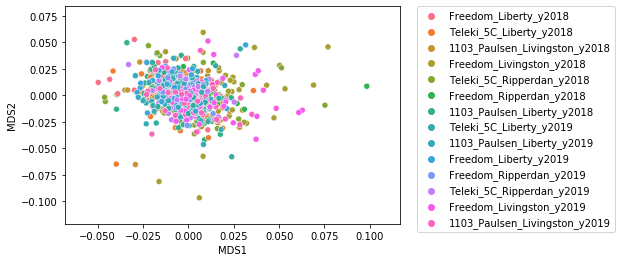

In [28]:
sns.scatterplot(data=cab_df, x="MDS1", y="MDS2", hue="unique")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#### Plot out log of avg distance as boxplot by rootstock-location paired by year

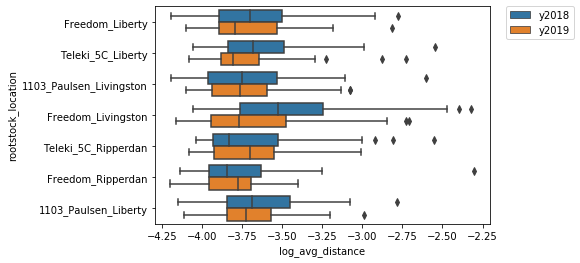

In [29]:
sns.boxplot(data=cab_df, x="log_avg_distance", y="rootstock_location", hue="year", dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Visualize difference in shape between two groups

## We will compare the overall average Cabernet Sauvignon leaf to Freedom/Livingston/2018 (based on visualization above)

#### Calculate the mean Cabernet Sauvignon leaf

In [30]:
cab_arr = np.array(cab_shapes)
mean_cab = np.mean(cab_arr, axis=0)

#### Calculate the mean Freedom-Livingston-2018 leaf

In [31]:
free_live_18_shapes = []

for i in range(len(cab_shapes)):
    
    if cab_unique[i] == 'Freedom_Livingston_y2018':
        free_live_18_shapes.append(cab_shapes[i])
    
free_live_18_arr = np.array(free_live_18_shapes)
mean_free_live_18 = np.mean(free_live_18_arr, axis=0)      

#### Plot the mean Cab leaf against the mean of Freedom-Livingston-2018

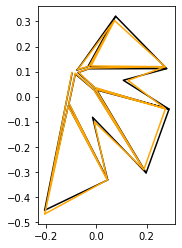

In [32]:
cab_col = "k"
free_live_18_col = "orange"

plt.plot(mean_cab[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         mean_cab[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], c=cab_col)
plt.plot(mean_cab[[0,13,14,15,16,17,18,19,20],0],
         mean_cab[[0,13,14,15,16,17,18,19,20],1], c=cab_col)


plt.plot(mean_free_live_18[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         mean_free_live_18[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], c=free_live_18_col)
plt.plot(mean_free_live_18[[0,13,14,15,16,17,18,19,20],0],
         mean_free_live_18[[0,13,14,15,16,17,18,19,20],1], c=free_live_18_col)

plt.gca().set_aspect("equal")

#### Magnify differences of Freedom-Livingston-2018 against mean Cab and plot against each other

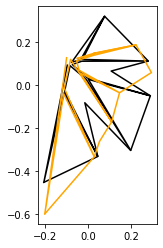

In [33]:
magnification = 10

magnified_leaf = (mean_free_live_18 - mean_cab)*magnification + mean_cab

cab_col = "k"
magnifiy_col = "orange"

plt.plot(mean_cab[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         mean_cab[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], c=cab_col)
plt.plot(mean_cab[[0,13,14,15,16,17,18,19,20],0],
         mean_cab[[0,13,14,15,16,17,18,19,20],1], c=cab_col)


plt.plot(magnified_leaf[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         magnified_leaf[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1], c=magnifiy_col)
plt.plot(magnified_leaf[[0,13,14,15,16,17,18,19,20],0],
         magnified_leaf[[0,13,14,15,16,17,18,19,20],1], c=magnifiy_col)

plt.gca().set_aspect("equal")

#### Plot a range of maagnification values on top of each other

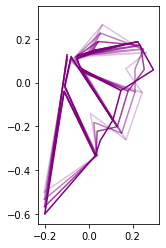

In [34]:
n = 5 # number of gradients
max_range = 10 # maximum magnification
mag_vals = np.linspace(1,max_range,n) # calculate range of magnification values
min_alpha = 0 # a minimum alpha for the gradient
alphas = np.linspace(min_alpha,1,n) # calculate a gradient of alphas
col = "purple" # color to use

for i in range(n):
    
    magnification = mag_vals[i]
    magnified_leaf = (mean_free_live_18 - mean_cab)*magnification + mean_cab
    
    plt.plot(magnified_leaf[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],0],
         magnified_leaf[[0,5,13,4,14,6,1,8,16,7,17,9,2,11,19,10,20,3],1],alpha=alphas[i], c=col)
    
    plt.plot(magnified_leaf[[0,13,14,15,16,17,18,19,20],0],
         magnified_leaf[[0,13,14,15,16,17,18,19,20],1],alpha=alphas[i], c=col)

    plt.gca().set_aspect("equal")
    
    

# Machine learning

## Format data to model

#### Currently 3D array is 1676 x 21 x 2. Flatten the 3rd axis x and y coords to a 2D array and reshape to 1676 x 42 for modeling

In [35]:
np.shape(proc_arr)

(1676, 21, 2)

In [36]:
flat_proc = proc_arr.reshape(1676, 42)
np.shape(flat_proc)

(1676, 42)

## Format labels

#### For Cab and Chard datasets combined, we need a label of scion-location-rootstock-year

In [37]:
# Create the labels

labels_list = []

for i in range(np.shape(flat_proc)[0]):
    
    scion = scion_list[i]
    location = location_list[i]
    rootstock = rootstock_list[i]
    year = year_list[i]
    
    labels_list.append(scion+"_"+location+"_"+rootstock+"_"+year)
    
label_arr = np.array(labels_list)

# Find unique labels

np.unique(label_arr)

array(['Cabernet_Sauvignon_Liberty_1103_Paulsen_y2018',
       'Cabernet_Sauvignon_Liberty_1103_Paulsen_y2019',
       'Cabernet_Sauvignon_Liberty_Freedom_y2018',
       'Cabernet_Sauvignon_Liberty_Freedom_y2019',
       'Cabernet_Sauvignon_Liberty_Teleki_5C_y2018',
       'Cabernet_Sauvignon_Liberty_Teleki_5C_y2019',
       'Cabernet_Sauvignon_Livingston_1103_Paulsen_y2018',
       'Cabernet_Sauvignon_Livingston_1103_Paulsen_y2019',
       'Cabernet_Sauvignon_Livingston_Freedom_y2018',
       'Cabernet_Sauvignon_Livingston_Freedom_y2019',
       'Cabernet_Sauvignon_Ripperdan_Freedom_y2018',
       'Cabernet_Sauvignon_Ripperdan_Freedom_y2019',
       'Cabernet_Sauvignon_Ripperdan_Teleki_5C_y2018',
       'Cabernet_Sauvignon_Ripperdan_Teleki_5C_y2019',
       'Chardonnay_Liberty_1103_Paulsen_y2018',
       'Chardonnay_Liberty_1103_Paulsen_y2019',
       'Chardonnay_Liberty_Freedom_y2018',
       'Chardonnay_Liberty_Freedom_y2019',
       'Chardonnay_Liberty_Teleki_5C_y2018',
       'Cha

#### Create a dictionary with numerical label values

In [38]:
label_dict = {

'Cabernet_Sauvignon_Liberty_1103_Paulsen_y2018':0,
'Cabernet_Sauvignon_Liberty_1103_Paulsen_y2019':1,
'Cabernet_Sauvignon_Liberty_Freedom_y2018':2,
'Cabernet_Sauvignon_Liberty_Freedom_y2019':3,
'Cabernet_Sauvignon_Liberty_Teleki_5C_y2018':4,
'Cabernet_Sauvignon_Liberty_Teleki_5C_y2019':5,
'Cabernet_Sauvignon_Livingston_1103_Paulsen_y2018':6,
'Cabernet_Sauvignon_Livingston_1103_Paulsen_y2019':7,
'Cabernet_Sauvignon_Livingston_Freedom_y2018':8,
'Cabernet_Sauvignon_Livingston_Freedom_y2019':9,
'Cabernet_Sauvignon_Ripperdan_Freedom_y2018':10,
'Cabernet_Sauvignon_Ripperdan_Freedom_y2019':11,
'Cabernet_Sauvignon_Ripperdan_Teleki_5C_y2018':12,
'Cabernet_Sauvignon_Ripperdan_Teleki_5C_y2019':13,
'Chardonnay_Liberty_1103_Paulsen_y2018':14,
'Chardonnay_Liberty_1103_Paulsen_y2019':15,
'Chardonnay_Liberty_Freedom_y2018':16,
'Chardonnay_Liberty_Freedom_y2019':17,
'Chardonnay_Liberty_Teleki_5C_y2018':18,
'Chardonnay_Liberty_Teleki_5C_y2019':19,
'Chardonnay_Livingston_Freedom_y2018':20,
'Chardonnay_Livingston_Freedom_y2019':21,
'Chardonnay_Livingston_Teleki_5C_y2018':22,
'Chardonnay_Livingston_Teleki_5C_y2019':23,
'Chardonnay_Ripperdan_1103_Paulsen_y2018':24,
'Chardonnay_Ripperdan_1103_Paulsen_y2019':25,
'Chardonnay_Ripperdan_Freedom_y2018':26,
'Chardonnay_Ripperdan_Freedom_y2019':27
    }

#### Use dictionary to create an array of numerical label values

In [39]:
num_labels = []

for i in range(len(label_arr)):
    
    lab = label_arr[i]
    number = label_dict[lab]
    num_labels.append(number)
    
num_label_arr = np.array(num_labels)

#### Perform machine learning and calculate confusion matrix

In [40]:
X = flat_proc # data
y = num_label_arr # labels 

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier
classifier = KNeighborsClassifier(n_neighbors=27)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[5 0 4 2 0 0 1 1 0 0 4 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 0 3 3 1 0 2 1 1 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 2 3 0 0 0 0 1 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 2 5 1 1 1 1 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 4 0 1 0 2 2 0 1 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 1 0 2 1 0 0 1 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [5 0 1 1 4 1 3 0 0 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 1 5 0 0 2 0 1 2 4 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 2 1 0 0 4 2 3 1 5 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 1 0 0 0 2 1 1 2 2 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 2 2 2 0 5 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 3 0 0 0 2 0 0 1 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 2 2 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 4 0 0 0 1 0 3 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 5 2 1 0 0 1 1 1 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 2 0 0 1 2 0 2 2 2 0 2 

#### Visualize confusion matrix

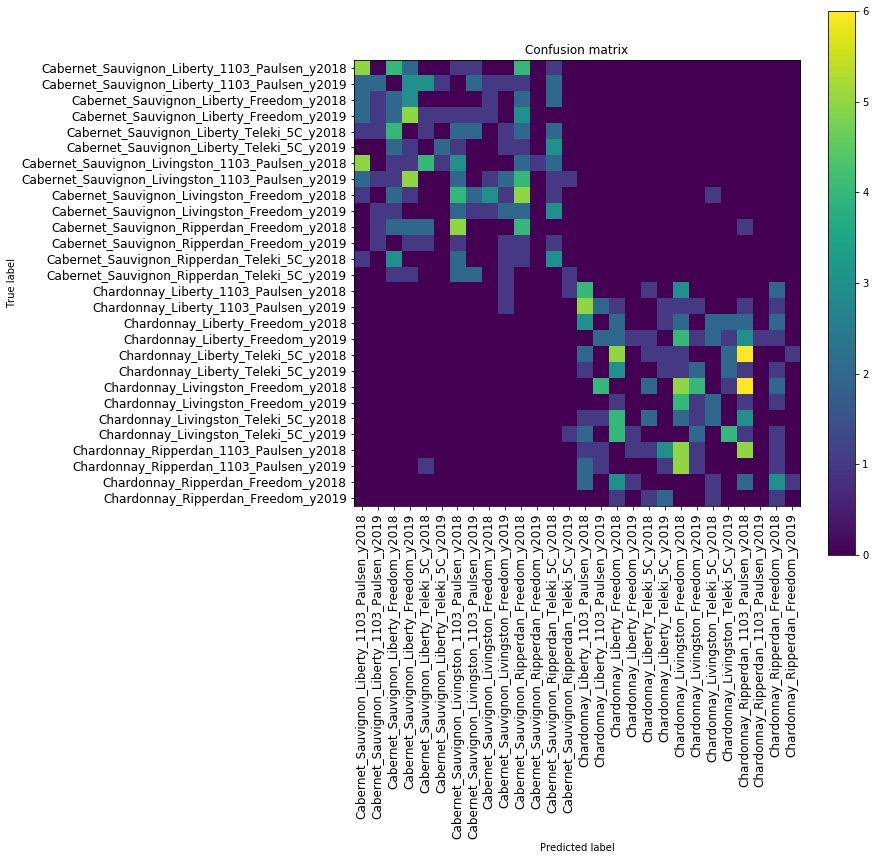

In [41]:
plt.figure(figsize=(10,10))

plt.imshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

x_ticks_labels = ['Cabernet_Sauvignon_Liberty_1103_Paulsen_y2018',
       'Cabernet_Sauvignon_Liberty_1103_Paulsen_y2019',
       'Cabernet_Sauvignon_Liberty_Freedom_y2018',
       'Cabernet_Sauvignon_Liberty_Freedom_y2019',
       'Cabernet_Sauvignon_Liberty_Teleki_5C_y2018',
       'Cabernet_Sauvignon_Liberty_Teleki_5C_y2019',
       'Cabernet_Sauvignon_Livingston_1103_Paulsen_y2018',
       'Cabernet_Sauvignon_Livingston_1103_Paulsen_y2019',
       'Cabernet_Sauvignon_Livingston_Freedom_y2018',
       'Cabernet_Sauvignon_Livingston_Freedom_y2019',
       'Cabernet_Sauvignon_Ripperdan_Freedom_y2018',
       'Cabernet_Sauvignon_Ripperdan_Freedom_y2019',
       'Cabernet_Sauvignon_Ripperdan_Teleki_5C_y2018',
       'Cabernet_Sauvignon_Ripperdan_Teleki_5C_y2019',
       'Chardonnay_Liberty_1103_Paulsen_y2018',
       'Chardonnay_Liberty_1103_Paulsen_y2019',
       'Chardonnay_Liberty_Freedom_y2018',
       'Chardonnay_Liberty_Freedom_y2019',
       'Chardonnay_Liberty_Teleki_5C_y2018',
       'Chardonnay_Liberty_Teleki_5C_y2019',
       'Chardonnay_Livingston_Freedom_y2018',
       'Chardonnay_Livingston_Freedom_y2019',
       'Chardonnay_Livingston_Teleki_5C_y2018',
       'Chardonnay_Livingston_Teleki_5C_y2019',
       'Chardonnay_Ripperdan_1103_Paulsen_y2018',
       'Chardonnay_Ripperdan_1103_Paulsen_y2019',
       'Chardonnay_Ripperdan_Freedom_y2018',
       'Chardonnay_Ripperdan_Freedom_y2019']

plt.gca().set_xticks(np.arange(0,28,1))
plt.gca().set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=12)

plt.gca().set_yticks(np.arange(0,28,1))
plt.gca().set_yticklabels(x_ticks_labels, rotation='horizontal', fontsize=12)

plt.show()